In [2]:
import numpy, pandas 
import matplotlib.pyplot as plt 
from pandas import DataFrame
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

df = pandas.read_csv('SeaPlaneTravel.csv')

df.head()

,Month,#Passengers
0,2003-01,112
1,2003-02,118
2,2003-03,132
3,2003-04,129
4,2003-05,121


In [3]:

df['Month'] = pandas.to_datetime(df['Month'])

indexed_df = df.set_index('Month')

ts = indexed_df['#Passengers']

ts.head(5)

Month
2003-01-01    112
2003-02-01    118
2003-03-01    132
2003-04-01    129
2003-05-01    121
Name: #Passengers, dtype: int64

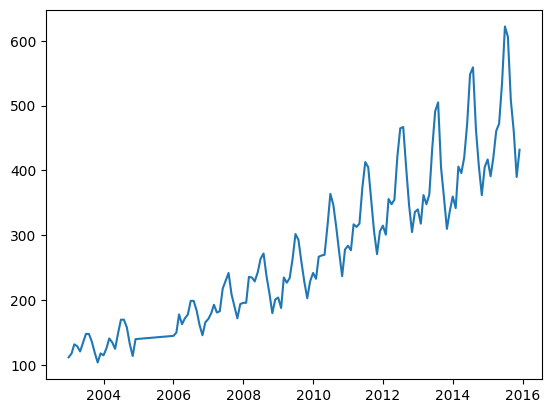

In [4]:
plt.plot(ts)

plt.show()

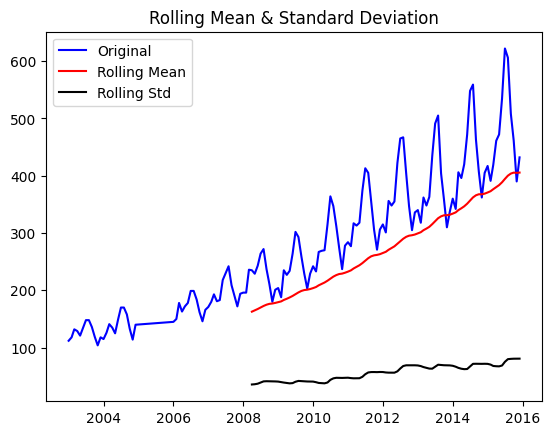

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [5]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pandas.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(ts)

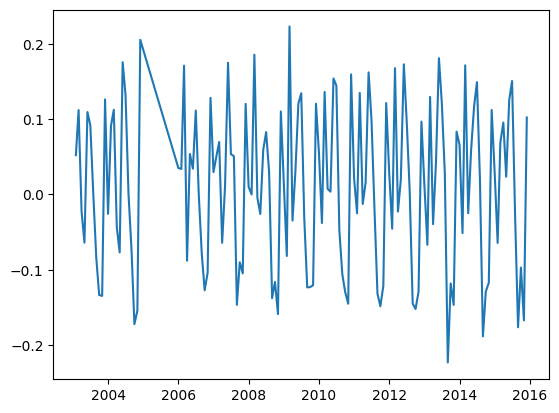

In [6]:
ts_log = numpy.log(ts)

ts_log_diff = ts_log - ts_log.shift()

plt.plot(ts_log_diff)

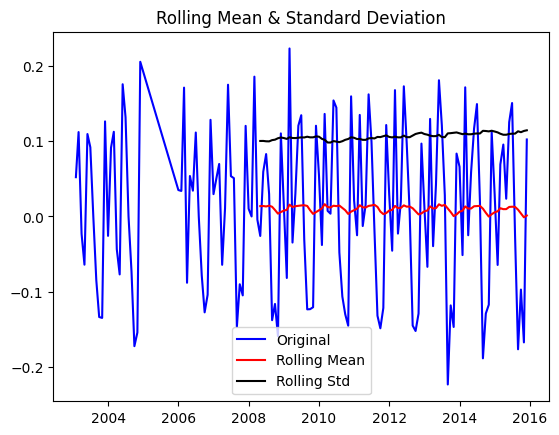

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [7]:
ts_log_diff.dropna(inplace=True)

test_stationarity(ts_log_diff)

In [8]:
#ACF and PACF

lag_acf = acf(ts_log_diff, nlags=10)

lag_pacf = pacf(ts_log_diff, nlags=10, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

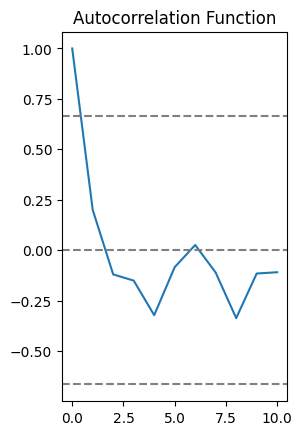

In [9]:
#Plot ACF: 

plt.subplot(121) 

plt.plot(lag_acf)

plt.axhline(y=0,linestyle='--',color='gray')

plt.axhline(y=-7.96/numpy.sqrt(len(ts_log_diff)),linestyle='--',color='gray')

plt.axhline(y=7.96/numpy.sqrt(len(ts_log_diff)),linestyle='--',color='gray')

plt.title('Autocorrelation Function')

Text(0.5, 1.0, 'RSS: nan')

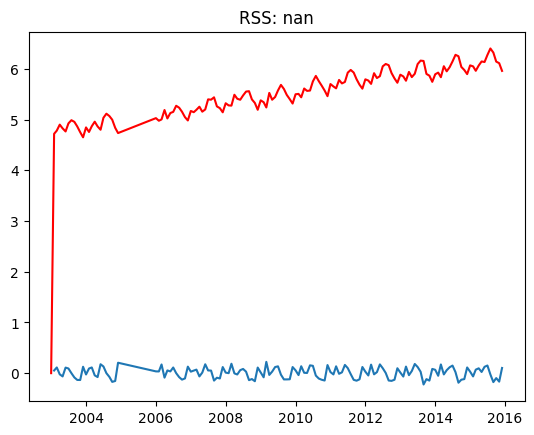

In [10]:
model = ARIMA(ts_log, order=(2, 1, 1))  

results_ARIMA = model.fit()  

plt.plot(ts_log_diff)

plt.plot(results_ARIMA.fittedvalues, color='red')

plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 129.732
Date:                Sun, 09 Apr 2023   AIC                           -251.464
Time:                        18:51:42   BIC                           -239.612
Sample:                             0   HQIC                          -246.648
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9792      0.100      9.839      0.000       0.784       1.174
ar.L2         -0.3740      0.118     -3.177      0.001      -0.605      -0.143
ma.L1         -0.8303      0.102     -8.118      0.0

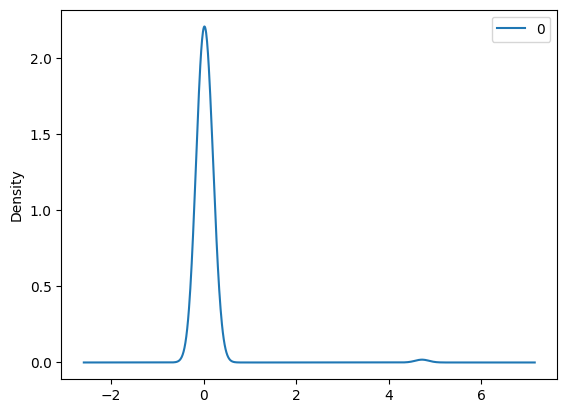

In [11]:

print(results_ARIMA.summary())

# plot residual errors

residuals = DataFrame(results_ARIMA.resid)

residuals.plot(kind='kde')

print(residuals.describe())


In [12]:
predictions_ARIMA_diff = pandas.Series(results_ARIMA.fittedvalues, copy=True)

print (predictions_ARIMA_diff.head())

Month
2003-01-01    0.000000
2003-02-01    4.718499
2003-03-01    4.781493
2003-04-01    4.899545
2003-05-01    4.825728
dtype: float64


Text(0.5, 1.0, 'RMSE: inf')

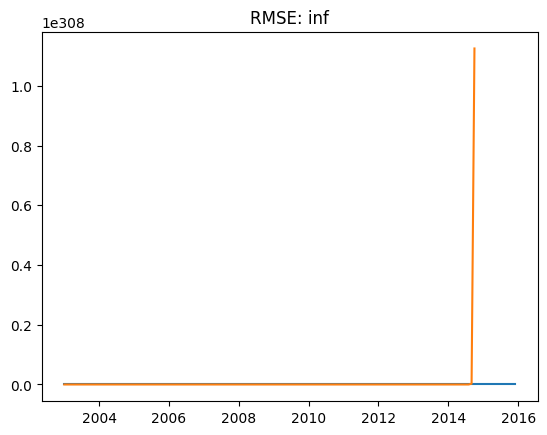

In [13]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

predictions_ARIMA_log = pandas.Series(ts_log.iloc[0], index=ts_log.index)

predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

predictions_ARIMA = numpy.exp(predictions_ARIMA_log)

plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% numpy.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [14]:
size = int(len(ts_log) - 15)

train, test = ts_log[0:size], ts_log[size:len(ts_log)]

history = [x for x in train]

predictions = list()

In [15]:
size = int(len(ts_log) - 15)

train, test = ts_log[0:size], ts_log[size:len(ts_log)]

history = [x for x in train]

predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')

for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)

print('predicted=%f, expected=%f' % (numpy.exp(yhat), numpy.exp(obs)))

Printing Predicted vs Expected Values...


predicted=386.206360, expected=432.000000


In [16]:
error = mean_squared_error(test, predictions)

print('\n')

print('Printing Mean Squared Error of Predictions...')

print('Test MSE: %.6f' % error)

predictions_series = pandas.Series(predictions, index = test.index)



Printing Mean Squared Error of Predictions...
Test MSE: 0.008601


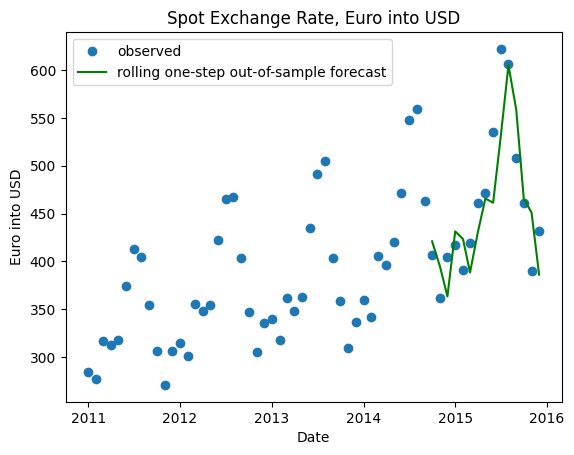

In [17]:
fig, ax = plt.subplots()

ax.set(title='Spot Exchange Rate, Euro into USD', xlabel='Date', ylabel='Euro into USD')

ax.plot(ts[-60:], 'o', label='observed')

ax.plot(numpy.exp(predictions_series), 'g', label='rolling one-step out-of-sample forecast')

legend = ax.legend(loc='upper left')

legend.get_frame().set_facecolor('w')